In this notebook, I work on implementing a randAug model using the CIFAR10 dataset. I moved away from PCam due to issues I was having from it, but would like to revist that dataset. 

In [1]:
from fastai import *
from fastai.vision.all import *
from fastai.imports import *
import cv2, os
from torchvision import transforms as T
from torchvision.transforms import functional as F
import albumentations as A
import copy
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler


# Import our custom module for preprocessing
from ImagenetDataset import ImagenetDataset

In [2]:
# Data is already downloaded
root = Path("D:\\tensorflow_datasets\\cifar10")

In [3]:
# get our training images and our test images, which we will use for validation
train_images = get_image_files(root/"train")
val_images = get_image_files(root/"test")

We will need to use dataframes since albumentations uses arrays to apply the augmentations

In [4]:
# Create a df using the labels (file names) and image names
def create_df(paths):
    names = [str(img.name) for img in paths]
    labels = [str(img.parent).split("\\")[-1] for img in paths]
    data = np.array([names, labels]).T
    np.random.shuffle(data)
    return pd.DataFrame(data,columns=["image", "label"])

# Make our training df
train_df = create_df(train_images)
train_df.head()

,image,label
0,2355.png,dog
1,1212.png,automobile
2,4629.png,bird
3,0059.png,airplane
4,2885.png,bird


In [5]:
valid_df = create_df(val_images)
valid_df.head()

,image,label
0,0949.png,dog
1,0847.png,deer
2,0014.png,bird
3,0931.png,automobile
4,0016.png,cat


In [6]:
label_dict = {l:i for i,l in enumerate(train_df["label"].unique())}
label_dict

{'dog': 0,
 'automobile': 1,
 'bird': 2,
 'airplane': 3,
 'horse': 4,
 'cat': 5,
 'deer': 6,
 'frog': 7,
 'truck': 8,
 'ship': 9}

In [7]:
def randAugment(N, M, p):

    shift_x = np.linspace(0,150,10)
    shift_y = np.linspace(0,150,10)
    rot = np.linspace(0,30,10)
    shear = np.linspace(0,10,10)
    sola = np.linspace(0,256,10)
    post = [4,4,5,5,6,6,7,7,8,8]
    cont = [np.linspace(-0.8,-0.1,10),np.linspace(0.1,2,10)]
    bright = np.linspace(0.1,0.7,10)
    shar = np.linspace(0.1,0.9,10)
    cut = np.linspace(0,60,10)

    Aug =[A.ShiftScaleRotate(shift_limit_x=shift_x[M], rotate_limit=0, shift_limit_y=0, shift_limit=shift_x[M], p=p),
        A.ShiftScaleRotate(shift_limit_y=shift_y[M], rotate_limit=0, shift_limit_x=0, shift_limit=shift_y[M], p=p),
        A.Affine(rotate=rot[M], p=p),
        A.Affine(shear=shear[M], p=p),
        A.InvertImg(p=p),
        A.Equalize(p=p),
        A.Solarize(threshold=sola[M], p=p),
        A.Posterize(num_bits=post[M], p=p),
        #the following two need to be combined as there is a new class
        A.RandomContrast(limit=[cont[0][M], cont[1][M]], p=p),
        A.RandomBrightness(limit=bright[M], p=p),
        A.Sharpen(alpha=shar[M], lightness=shar[M], p=p)]


    ops = np.random.choice(Aug, N)
    
    transforms = A.Compose(ops)
    return transforms, ops

C:\Users\suraj\anaconda3\lib\site-packages\albumentations\augmentations\transforms.py:1826: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
C:\Users\suraj\anaconda3\lib\site-packages\albumentations\augmentations\transforms.py:1800: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


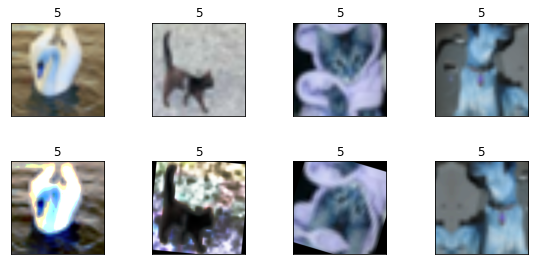

In [8]:
idx = np.random.randint(0,len(train_images)-1, 4)
fig, ax = plt.subplots(2,4, figsize=(8,4))
fig.tight_layout()
M = 5
for i in range(2):
    for j in range(4):
        img = cv2.imread(str(train_images[int(idx[j])]))
        img = cv2.resize(img,(254,254))
        if i == 1:
            transforms, ops = randAugment(2, M, 1)
            img = transforms(image=img)["image"]
        ax[i][j].get_xaxis().set_visible(False)
        ax[i][j].get_yaxis().set_visible(False)
        ax[i][j].set_title(str(M))
        ax[i][j].imshow(img)

In [9]:
len(train_df["label"].unique())

10

In [10]:
dataset = ImagenetDataset(root/"train", train_df, label_dict=label_dict)
dataset.__getitem__(1)[1]

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [11]:
def create_dataloaders(root, train_df, valid_df, label_dict, transforms, dim = 256, bs=64):

    data_loaders = {}
    dataset_sizes = {}

    train_dataset = ImagenetDataset(path=root/"train", df=train_df, label_dict=label_dict, dim=dim, transforms=transforms)
    valid_dataset = ImagenetDataset(path=root/"test", df=valid_df, label_dict=label_dict, dim=dim)

    data_loaders["train"] = torch.utils.data.DataLoader(train_dataset, batch_size=bs,shuffle=True, num_workers=2)
    data_loaders["val"] = torch.utils.data.DataLoader(valid_dataset, batch_size=bs,shuffle=False, num_workers=2)

    dataset_sizes["train"] = len(train_dataset)
    dataset_sizes["val"] = len(valid_dataset)

    return data_loaders, dataset_sizes


In [12]:
model = models.resnet18()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model.fc

Linear(in_features=512, out_features=10, bias=True)

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [14]:
def train_model(model, criterion, optimizer, scheduler, max_M=9, num_epochs=2):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    N=2;M=0;p=0.5

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
    
        transforms, ops = randAugment(N=N, M=M, p=p)
        dataloaders, dataset_sizes = create_dataloaders(root, train_df, valid_df, label_dict, bs=64, transforms=transforms)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = torch.argmax(input = outputs, dim = 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == torch.argmax(input = labels, dim = 1))
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            elif phase == 'val' and epoch_acc < best_acc:
                stp = int((9-M)*((best_acc-epoch_acc)/best_acc))
                M += max(1,stp)
                M = min(M, max_M)
                if M < max_M:
                  print("Augmentaion Magnitude Changed To : {}\n".format(M))


    print('Best Val Acc: {:4f}'.format(best_acc))
    

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Whenever epoch accuracy is lower than our best accuracy in our validation set, we increment M up to a defined maximum. We can also modify N, which is the number of transformations. 

In [15]:
model = models.resnet18()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model.fc
model.to(device)
param = model.parameters()
optimizer_ft=torch.optim.Adam(param, lr=0.001)
criterion=nn.BCEWithLogitsLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)

In [16]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, max_M=9, num_epochs=100)

Epoch 0/99
----------
train Loss: 0.3287 Acc: 0.1017
val Loss: 0.3275 Acc: 0.0964
Epoch 1/99
----------
train Loss: 0.3269 Acc: 0.0976
val Loss: 0.3266 Acc: 0.1059
Epoch 2/99
----------
train Loss: 0.3265 Acc: 0.1032
val Loss: 0.3264 Acc: 0.1064
Epoch 3/99
----------
train Loss: 0.3261 Acc: 0.1027
val Loss: 0.3319 Acc: 0.0936
Augmentaion Magnitude Changed To : 1

Epoch 4/99
----------
train Loss: 0.3260 Acc: 0.1004
val Loss: 0.3263 Acc: 0.0920
Augmentaion Magnitude Changed To : 2

Epoch 5/99
----------
train Loss: 0.3258 Acc: 0.0975
val Loss: 0.3264 Acc: 0.0936
Augmentaion Magnitude Changed To : 3

Epoch 6/99
----------
train Loss: 0.3256 Acc: 0.0995
val Loss: 0.3261 Acc: 0.1058
Augmentaion Magnitude Changed To : 4

Epoch 7/99
----------
train Loss: 0.3255 Acc: 0.1029
val Loss: 0.3260 Acc: 0.1034
Augmentaion Magnitude Changed To : 5

Epoch 8/99
----------
train Loss: 0.3254 Acc: 0.1042
val Loss: 0.3254 Acc: 0.0920
Augmentaion Magnitude Changed To : 6

Epoch 9/99
----------
train Loss: 

train Loss: 0.3250 Acc: 0.1071
val Loss: 0.3254 Acc: 0.1049
Epoch 96/99
----------
train Loss: 0.3250 Acc: 0.1051
val Loss: 0.3254 Acc: 0.1022
Epoch 97/99
----------
train Loss: 0.3250 Acc: 0.1072
val Loss: 0.3254 Acc: 0.1051
Epoch 98/99
----------
train Loss: 0.3249 Acc: 0.1083
val Loss: 0.3254 Acc: 0.1031
Epoch 99/99
----------
train Loss: 0.3249 Acc: 0.1068
val Loss: 0.3254 Acc: 0.1028
Best Val Acc: 0.106800


Even after 100 epochs, the accuracy hasn't really changed. This might be due to the complexity of the model, or it just isn't set up very well - it definitely needs more work. Maybe the CIFAR10 dataset isn't a great choice for how this model is set up as well. I learned a lot about trying data augmentation methods, and would like to continue working on this model specifically in the future to improve it (and get the PCam set working with it)